# Multi class classification of individual forest trees from UAV LiDAR point cloud

## Dimitrios Tilemachos Davarakis


### Scope

Build ML classification models to: 

- Classify forest trees as coniferous or deciduous (**Binary classification**)
- Identify tree species (**Multiclass classification**)

### Dataset

The dataset is a collection of 192 individual trees manually extracted from a large UAV LiDAR point cloud over a dense mixed forest. The dataset contains a mix of coniferous and deciduous trees (101 and 91 respectively). The trees belong to 6 species (fir, pine, spruce, alder, aspen, birch, tilia).

Dataset is a subset UAV LiDAR point cloud dataset provided by https://www.kaggle.com/datasets/sentinel3734/uav-point-clouds-of-individual-trees/data

The point cloud of each individual tree is stored in a `.las` file

Quietly install packages for working with point cloud files.Quietly install packages for working with point cloud files.

In [1]:
%%capture
!pip install laspy
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install geopandas
!pip install rasterio
!pip install scipy
!pip install shapely
!pip install -U scikit-learn
!pip install tqdm

In [2]:
# import all nessesary liblaries
import glob
import tqdm
import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scipy.stats
import seaborn as sns
import shapely
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, confusion_matrix 
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### Loading and visualizing individual trees in UAV LiDAR point clouds

In order for the following code to run correctly, you need to **change the following argument `folder_name`** with the location of the `pointcloud-tree-classification` folder.

**Be careful**: Do not remove the `r` character!!!

In [3]:
folder_name = r"C:\Users\jimyd\Documents\dimitris\scorce code\pointcloud-tree-classification"

new_folder_name = folder_name + r"\archive\*\*.las"

Read pointcloud files. **There should be 192 individual files**. Otherwise the file loading process failed. Please check the name of the folder you have previously inserted!

In [4]:
file_paths = glob.glob(new_folder_name) 
file_paths.sort()
print("There are %d individual trees." % (len(file_paths)))

There are 192 individual trees.


Create a dataframe (a.k.a data table) to store the species for each individual tree

In [5]:
data = pd.DataFrame({"path": file_paths})
data["species"] = data["path"].map(lambda p: p.split("\\")[-2])


Print 5 randomply selected entries

In [6]:
data.sample(n=5)

,path,species
21,C:\Users\jimyd\Documents\dimitris\scorce code\...,Alder
76,C:\Users\jimyd\Documents\dimitris\scorce code\...,Fir
161,C:\Users\jimyd\Documents\dimitris\scorce code\...,Spruce
128,C:\Users\jimyd\Documents\dimitris\scorce code\...,Pine
20,C:\Users\jimyd\Documents\dimitris\scorce code\...,Alder


### Data Analysis

Compute the number of coniferous and deciduous trees

In [7]:
conifers = {"Spruce", "Fir", "Pine"}
counts = data.value_counts("species").reset_index()
counts["Type"] = counts["species"].map(lambda x: "Coniferous" if x in conifers else "Deciduous")
counts.rename(columns={ counts.columns[1]: "count" }, inplace = True)
data["type"] = data["species"].map(lambda x: "Coniferous" if x in conifers else "Deciduous")

Print the number of trees per each type (Coniferous or Deciduous) and per each species

In [8]:
counts

,species,count,Type
0,Spruce,44,Coniferous
1,Fir,37,Coniferous
2,Alder,26,Deciduous
3,Birch,25,Deciduous
4,Aspen,23,Deciduous
5,Pine,20,Coniferous
6,Tilia,17,Deciduous


Print the number of trees per type

In [9]:
outer = counts.groupby('Type').sum()
outer = outer.drop(['species'],axis=1)
outer

,count
Type,
Coniferous,101
Deciduous,91


Print per each tree type the number of trees belonging to a specific species.

In [10]:
inner = counts.groupby(['Type', 'species']).sum()
inner

count
Type       species       
Coniferous Fir         37
           Pine        20
           Spruce      44
Deciduous  Alder       26
           Aspen       23
           Birch       25
           Tilia       17

Print a pie plot which visually shows the number of trees per type.

In [11]:
# save the labels of all species of trees
inner_labels = inner.index.get_level_values(1)
inner_labels

Index(['Fir', 'Pine', 'Spruce', 'Alder', 'Aspen', 'Birch', 'Tilia'], dtype='object', name='species')

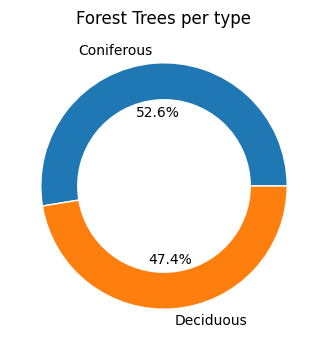

In [12]:
fig, ax = plt.subplots(figsize=(6,4))
size = 0.3

ax.pie(outer.values.flatten(), radius=1,
       labels=outer.index,
       autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))
ax.set(aspect="equal", title='Forest Trees per type')
plt.show()

Print a pie plot which visually shows the number of trees per species.

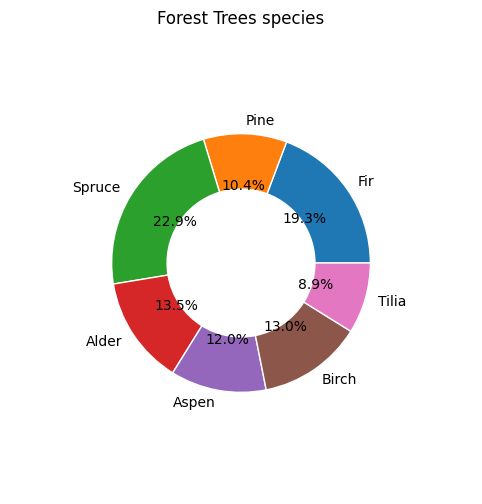

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
size = 0.3


ax.pie(inner.values.flatten(), radius=1-size, 
       labels = inner_labels,
       autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))


ax.set(aspect="equal", title='Forest Trees species')

plt.show()

Display one sample (randomly selected) by each species

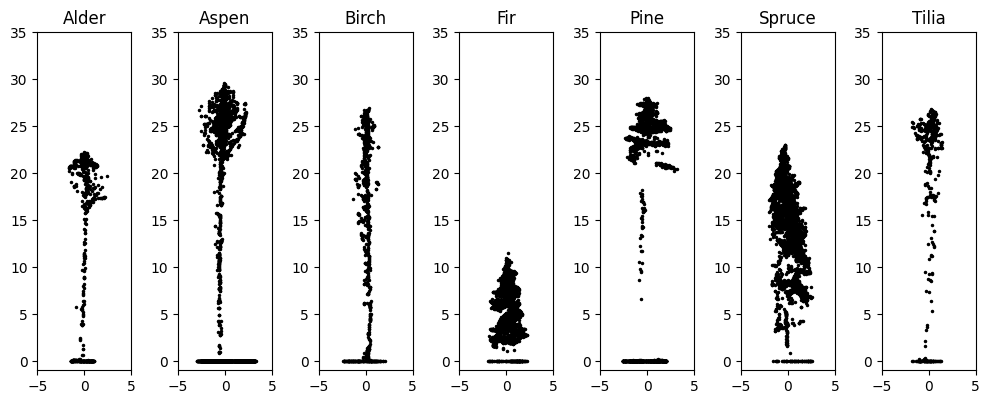

In [14]:
rng = np.random.default_rng(seed=1917)
unique_species = data["species"].unique()

fig, axes = plt.subplots(1, len(unique_species), figsize=(10, 7), tight_layout=True)

for ax, species in zip(axes, unique_species):
    sample = data[data["species"] == species].sample(n=1, random_state=rng).reset_index(drop=True)
    las = laspy.read(sample.loc[0, "path"])
    X, Y, Z = np.rollaxis(las.xyz, axis=1)  # (N, dim) -> (dim, N)
    ax.plot(X - X.mean(), Z, marker=".", linestyle="", markersize=3, color="k")
    ax.set_aspect("equal")
    ax.set_title(sample.loc[0, "species"])
    ax.set_ylim(-1, 35)
    ax.set_xlim(-5, 5)

In [15]:
# save the labels of all unique species
unique_species = data["species"].unique()
unique_species

array(['Alder', 'Aspen', 'Birch', 'Fir', 'Pine', 'Spruce', 'Tilia'],
      dtype=object)

Display one sample (randomly selected) by each specie in 3D

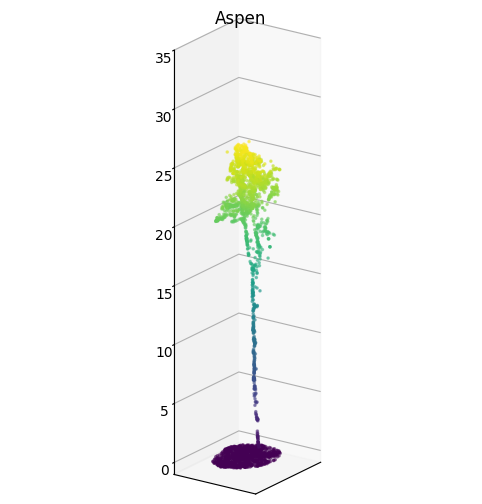

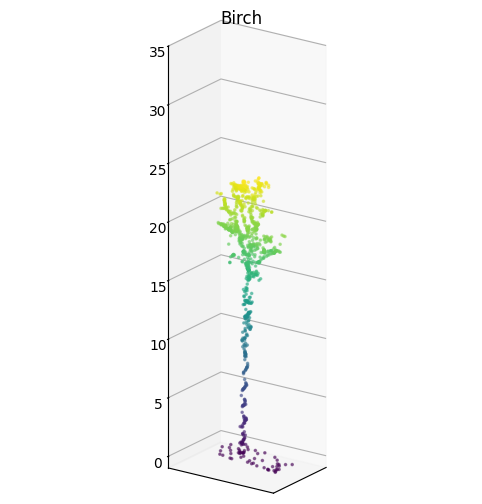

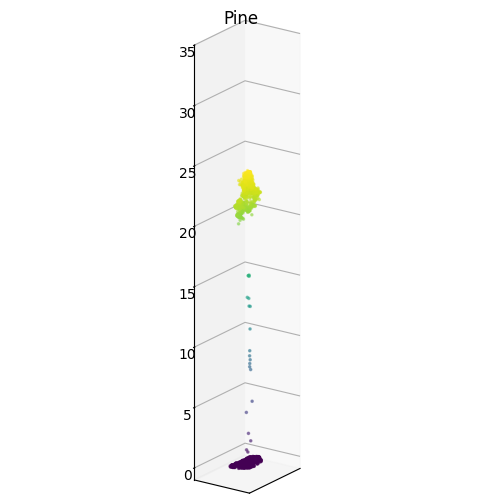

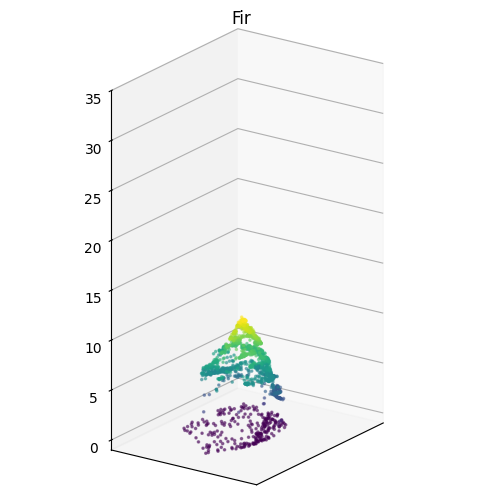

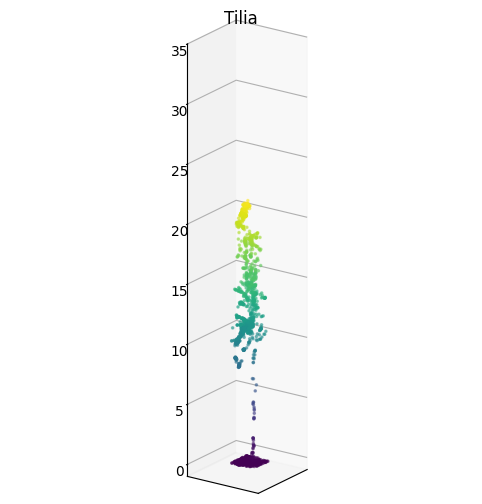

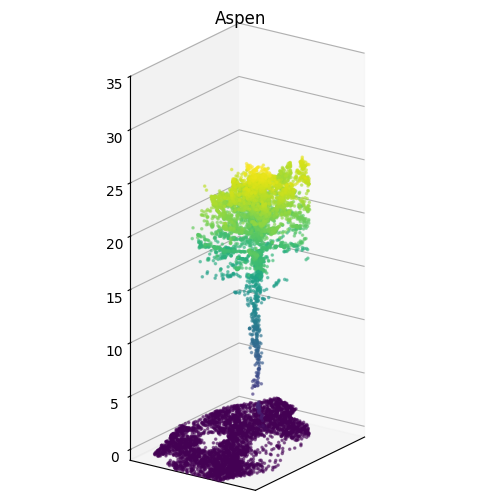

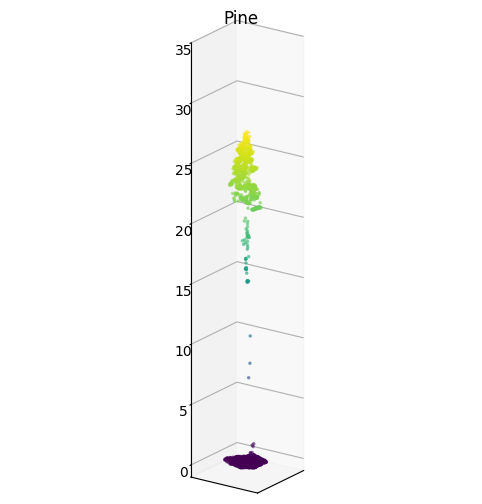

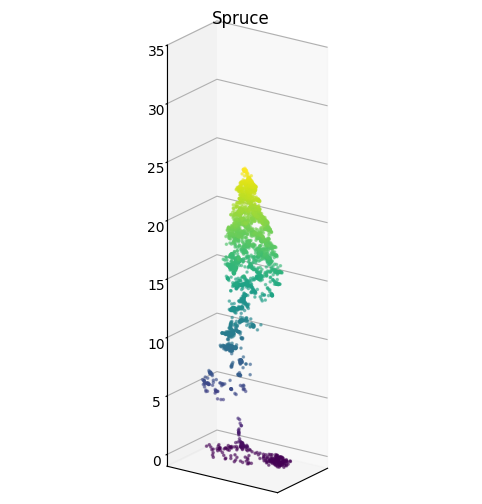

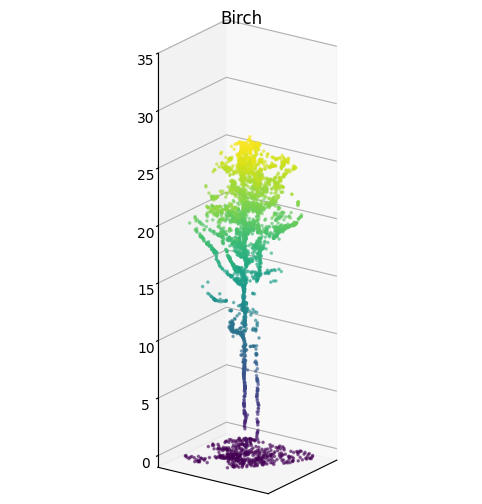

In [16]:
for i in range(9): #number of plots
    fig = plt.figure(figsize=(10, 6))
    
    sample = data.sample(n=1, random_state=rng).reset_index(drop=True)
    las = laspy.read(sample.loc[0, "path"])
    X, Y, Z = np.rollaxis(las.xyz, axis=1)

    ax = fig.add_subplot(projection="3d")
    ax.scatter(X - X.mean(), Y - Y.mean(), Z, s=10, c=Z, marker=".", alpha=0.5, cmap="viridis")
    ax.set_proj_type("ortho")
    ax.set_aspect("equal")
    ax.view_init(elev=20, azim=35, roll=0)
    ax.set_title(sample.loc[0, "species"])
    ax.set_xlim(-5, 5)    
    ax.set_ylim(-5, 5)
    ax.set_zlim(-1, 35)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

Display in 3D samples from a specific tree specie (i.e PINE)

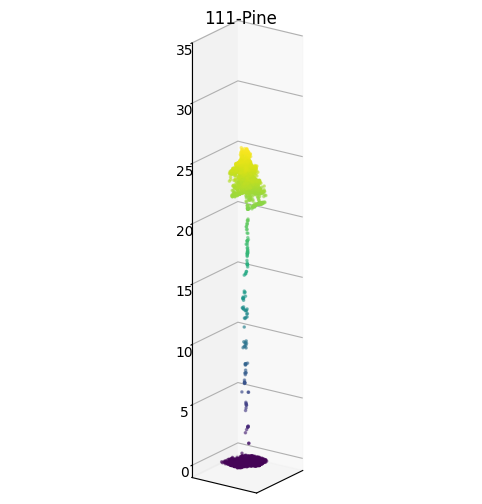

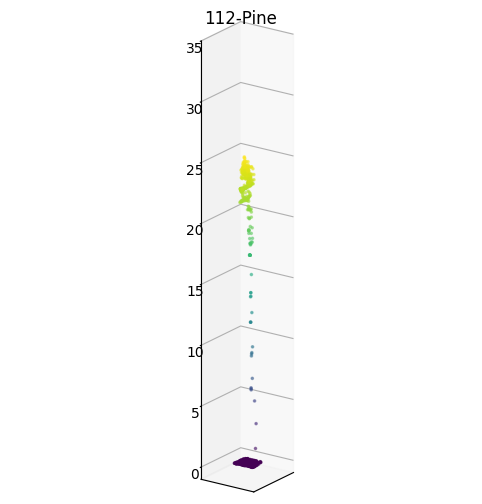

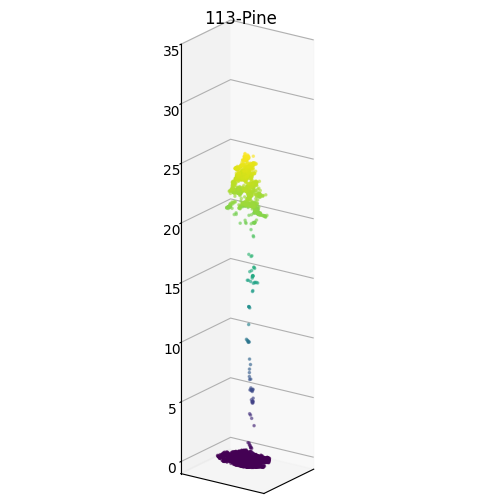

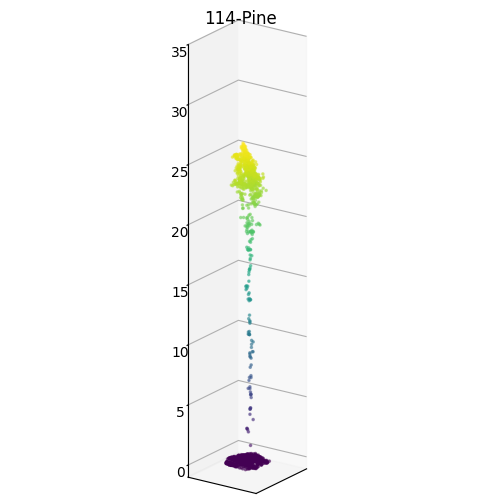

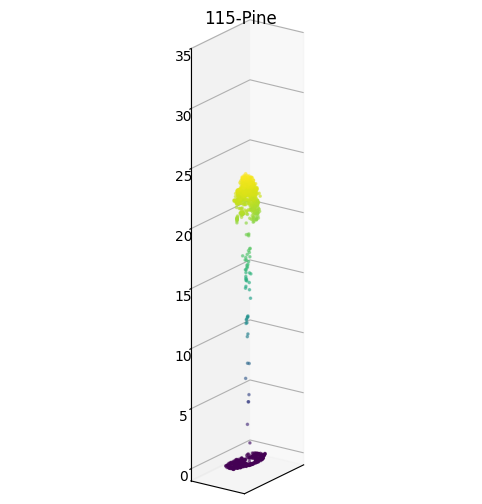

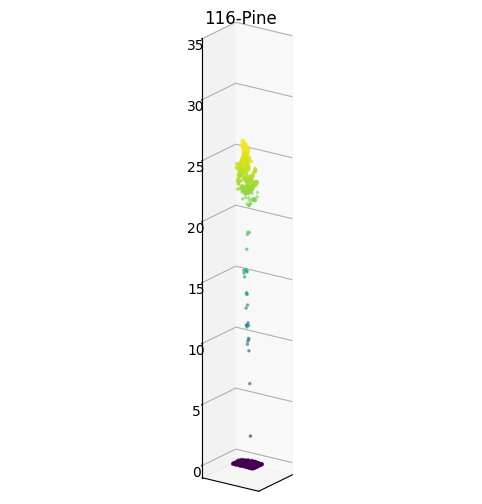

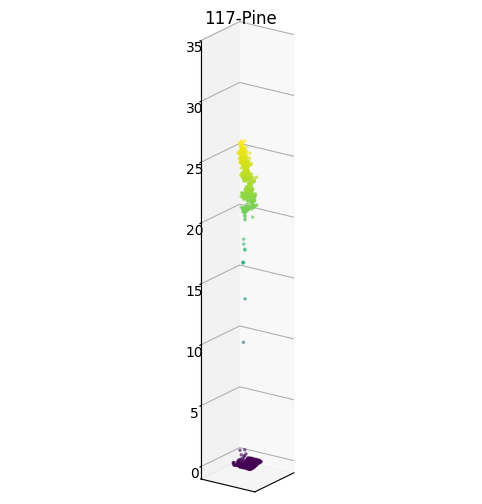

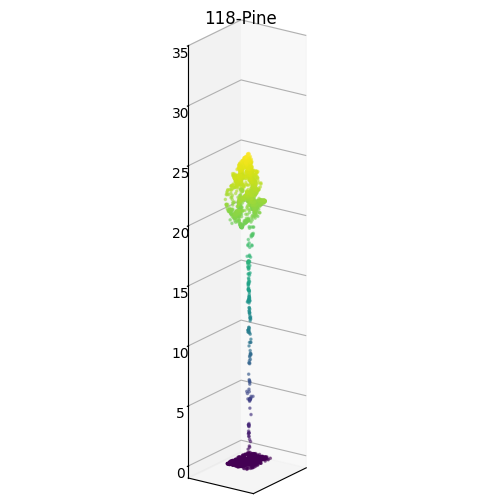

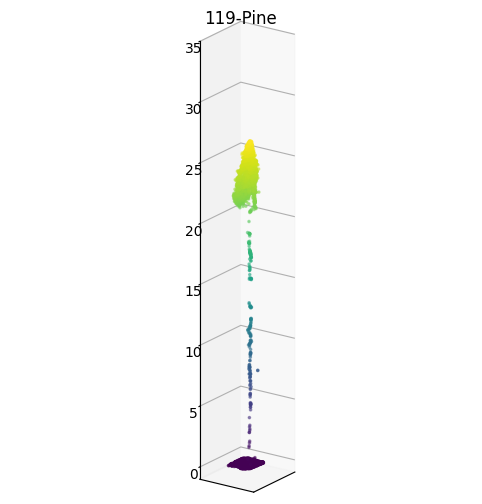

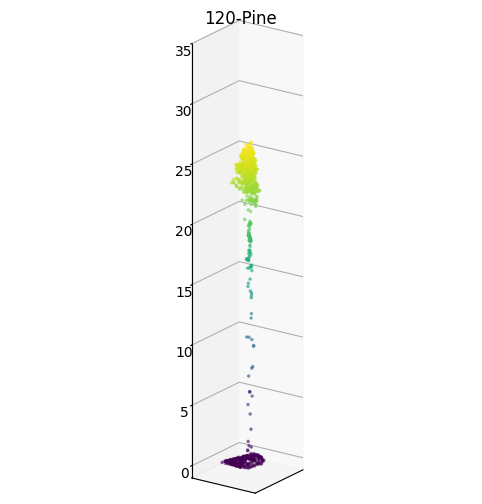

In [17]:
specie = 'Pine'
specific_data = data.loc[data['species'] == specie]
for i in range(10): #number of pines in the plot
    fig = plt.figure(figsize=(10, 6))

    sample = specific_data.iloc[[i]]
    las = laspy.read(sample['path'].values[0])
    X, Y, Z = np.rollaxis(las.xyz, axis=1)

    ax = fig.add_subplot(projection="3d")
    ax.scatter(X - X.mean(), Y - Y.mean(), Z, s=10, c=Z, marker=".", alpha=0.5, cmap="viridis")
    ax.set_proj_type("ortho")
    ax.set_aspect("equal")
    ax.view_init(elev=20, azim=35, roll=0)
    ax.set_title(str(sample.index[0]) + '-' + specie)
    ax.set_xlim(-5, 5)    
    ax.set_ylim(-5, 5)
    ax.set_zlim(-1, 35)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

### Computing features

LiDAR scanning produces a point cloud which is a set of data points in space. These data points represent a 3D shape or object. Each data point is at least described by the point’s Cartesian coordinates (X, Y, Z). Each 3D shape or object is constructed by a huge number of data points depending on the configuration parameters set into the LiDAR scanner. The training of a machine learning algorithm on a dataset with a large number of variables requires a large amount of memory and computational resources while leading to overfitting training data and poor generalization in new data. To overcome this, a reduction of the number of variables that describe a 3D object is required by applying feature extraction techniques on the original dataset. **The feature extraction outcome is a new dataset with a small number of variables/features that still describes the original data with sufficient accuracy.**

Two types of features are extracted:

* Height distribution features:   [Woods et al. (2008)](https://www.researchgate.net/publication/229077837_Predicting_forest_stand_variables_from_LiDAR_data_in_the_Great_Lakes_-_St_Lawrence_forest_of_Ontario) suggest the mean, height, standard deviation, and absolute deviation of the distribution of LiDAR height measurements. Apart from that, Shannon entropy, skewness, kurtosis, and the deciles of LiDAR height measurements are also included.




* Eigenvalue characteristics derived from the X, Y, and Z coordinates of the point cloud: Seven (7) eigenvalue-based features were calculated based on the eigenvalues (λ1, λ2, λ3, where λ1 > λ2 > λ3) of the covariance matrix of the X, Y and Z coordinates of points ([Lucas et al. (2019)](https://www.researchgate.net/publication/330816368_Identification_of_Linear_Vegetation_Elements_in_a_Rural_Landscape_Using_LiDAR_Point_Clouds)).

Here feature extraction and creation of the new dataset is done. 

The `compute_cloud_features` function calculates the extracted features.

In [18]:
def compute_cloud_features(path: str, *, height_threshold: float = 1.0) -> dict:
    las = laspy.read(path)
    out = {}
    
    X, Y, Z = np.rollaxis(las.xyz, axis=1)
    
    height_mask = Z > height_threshold
    X, Y, Z = X[height_mask], Y[height_mask], Z[height_mask]
    
    # Height distribution features (Woods et al., 2008)
    out.update(
        {
            "z_max": Z.max(),
            "z_mean": Z.mean(),
            "z_std": Z.std(),
            "z_skew": scipy.stats.skew(Z),
            "z_kurt": scipy.stats.kurtosis(Z),
            "z_entropy": scipy.stats.entropy(Z),
            "pct_z_above_mean": np.mean(Z > Z.mean()),
            "pct_z_above_2": np.mean(Z > 2),
        }
    )
    
    for i, z in enumerate(np.percentile(Z, range(10, 100, 10)), 1):
        out.update({f"z_decile_{i}": z})
        
    counts, bins = np.histogram(Z, bins=np.linspace(Z.min(), Z.max(), 11))
    counts = np.cumsum(counts / Z.size)[:-1]
    for i, c in enumerate(counts, 1):
        out.update({f"z_cumrat_{i}": c})
    
    # Eigenvalue features (Lucas et al., 2019)
    covariance_matrix = np.cov(las.xyz, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    lambda1, lambda2, lambda3 = sorted(eigenvalues, reverse=True)
    
    out.update(
        {
            "linearity": (lambda1 - lambda2) / lambda1,
            "planarity": (lambda2 - lambda3) / lambda1,
            "scatter": lambda3 / lambda1,
            "omnivariance": np.cbrt(lambda1 * lambda2 * lambda3),
            "eigentropy": -lambda1 * np.log(lambda1) - lambda2 * np.log(lambda2) - lambda3 * np.log(lambda3),
            "sum_of_eigenvalues": lambda1 + lambda2 + lambda3,
            "curvature": lambda3 / (lambda1 + lambda2 + lambda3),
        }
    )
    
    return out

Extract features and create the new dataset to run the ML classification models

In [19]:
features = pd.json_normalize(data["path"].map(compute_cloud_features))
full = pd.concat([data, features], axis=1)
# print the calculated features of the first 5 rows
full.head()

,path,species,type,z_max,z_mean,z_std,z_skew,z_kurt,z_entropy,pct_z_above_mean,...,z_cumrat_7,z_cumrat_8,z_cumrat_9,linearity,planarity,scatter,omnivariance,eigentropy,sum_of_eigenvalues,curvature
0,C:\Users\jimyd\Documents\dimitris\scorce code\...,Alder,Deciduous,22.32,17.002780,4.597414,-1.020943,0.243232,5.973640,0.614634,...,0.351220,0.490244,0.690244,0.981076,0.012635,0.006289,2.468470,-196.083280,51.447456,0.006135
1,C:\Users\jimyd\Documents\dimitris\scorce code\...,Alder,Deciduous,24.23,17.315165,6.014095,-0.988109,-0.217612,6.379930,0.631496,...,0.365354,0.492913,0.710236,0.994329,0.003426,0.002245,2.124794,-409.841464,91.723780,0.002227
2,C:\Users\jimyd\Documents\dimitris\scorce code\...,Alder,Deciduous,23.67,19.881849,4.707022,-1.949824,3.479363,6.534839,0.691877,...,0.175070,0.282913,0.431373,0.991670,0.002417,0.005913,3.931215,-500.985193,108.771077,0.005830
3,C:\Users\jimyd\Documents\dimitris\scorce code\...,Alder,Deciduous,23.51,19.521968,4.200103,-2.012837,4.109174,6.191521,0.667992,...,0.157058,0.300199,0.610338,0.993375,0.001818,0.004808,3.167249,-459.420669,101.058292,0.004753
4,C:\Users\jimyd\Documents\dimitris\scorce code\...,Alder,Deciduous,23.21,18.474711,4.628113,-1.840038,2.974199,6.740684,0.670829,...,0.216799,0.363224,0.659478,0.980028,0.010519,0.009453,5.458378,-434.566054,97.947902,0.009183


### Dataset preprocessing

- Remove from the dataset the `path` information as it is irrelevant. 
- Replace any `infinite` values with `-1` in numerical fields

To train ML classification models two types of datasets need to be prepared: 
- `X` dataset that contains the features on which the ML model will be trained, and, 
- `y` dataset that contains the values that the ML model need to predict

The `X` dataset should not contain the `y` values!!

To that end, 

- Remove `type` information from `X` dataset and create the `y_binary` dataset to be used during Binary classification (Classification of forest trees as coniferous or deciduous)
- Remove `type` information from `X` dataset and create the `y_multi` dataset to be used during Multiclass classification (Identification of tree species)

In [20]:
X = full.drop(columns="path").copy()
y_binary = X.pop("type")
y_multi = X.pop("species")

X.loc[X["z_entropy"] == float("-inf"), "z_entropy"] = -1

Print the first 5 rows of `X` dataset

In [21]:
X.head()

,z_max,z_mean,z_std,z_skew,z_kurt,z_entropy,pct_z_above_mean,pct_z_above_2,z_decile_1,z_decile_2,...,z_cumrat_7,z_cumrat_8,z_cumrat_9,linearity,planarity,scatter,omnivariance,eigentropy,sum_of_eigenvalues,curvature
0,22.32,17.002780,4.597414,-1.020943,0.243232,5.973640,0.614634,0.995122,9.500,13.376,...,0.351220,0.490244,0.690244,0.981076,0.012635,0.006289,2.468470,-196.083280,51.447456,0.006135
1,24.23,17.315165,6.014095,-0.988109,-0.217612,6.379930,0.631496,0.995276,7.040,11.356,...,0.365354,0.492913,0.710236,0.994329,0.003426,0.002245,2.124794,-409.841464,91.723780,0.002227
2,23.67,19.881849,4.707022,-1.949824,3.479363,6.534839,0.691877,0.991597,13.199,17.572,...,0.175070,0.282913,0.431373,0.991670,0.002417,0.005913,3.931215,-500.985193,108.771077,0.005830
3,23.51,19.521968,4.200103,-2.012837,4.109174,6.191521,0.667992,0.996024,12.976,17.994,...,0.157058,0.300199,0.610338,0.993375,0.001818,0.004808,3.167249,-459.420669,101.058292,0.004753
4,23.21,18.474711,4.628113,-1.840038,2.974199,6.740684,0.670829,0.990919,11.970,16.250,...,0.216799,0.363224,0.659478,0.980028,0.010519,0.009453,5.458378,-434.566054,97.947902,0.009183


Print the first 5 rows of `y_binary` dataset

In [22]:
y_binary.head()

0    Deciduous
1    Deciduous
2    Deciduous
3    Deciduous
4    Deciduous
Name: type, dtype: object

Print the first 5 rows of `y_multi` dataset

In [23]:
y_multi.head()

0    Alder
1    Alder
2    Alder
3    Alder
4    Alder
Name: species, dtype: object

### Split dataset (60% - 40%)

After feature extraction, the data need to be split into **training (60%)** and **testing (40%)** datasets. The training dataset will feed into the model so that the model can learn the data patterns implied in the training dataset. **The model uses the testing set to improve its performance by modifying its internal parameters/weights and achieving convergence.** Also, the data is shuffled before the split which means that the data was randomized before splitting so the classes were randomly assigned to the training and testing datasets.In addition, the split was made in a stratified fashion which means that each dataset contains approximately the same percentage of samples of each target class as the original dataset.

In [24]:
X_train, X_test, y_binary_train, y_binary_test, y_multi_train, y_multi_test = train_test_split(
    X,
    y_binary,
    y_multi,
    test_size=0.4,
    random_state=68,
    shuffle=True,
    stratify=y_multi,
)

### Training strategy

- The data in each dataset is standardized by adjusting the data values to have a common scale and distribution. Through standardisation, the impact of outliers is reduced, and the ML algorithm’s convergence capability is improved.

- To train ML models that will work accurately for real data and will have the ability to generalize their performance in unseen data, cross-validation technique is used. k-fold cross-validation (k=10) separates all data into k subsets. Each subset is split into training and testing sets to train and test the model respectively. Therefore, k different models are trained with k different results. The final result is the average of k interim results. Cross-validation is used to ensure that the final trained models will be robust and will generalize well to new data.

Standardisation, Cross-validation and model training are performed for all models by constructing and applying an automated ML workflow known as `pipeline`.


### Metrics

To evaluate and assess the performance and the effectiveness of each trained model, a set of evaluation metrics needs to be selected. These metrics help to assess and compare the capability of each model to predict and generalize. The selected metrics are:
- **Accuracy**; Accuracy is the proportion of the total number of correct predictions that were correct.
- **Precision**; Precision is the proportion of positive cases that were correctly identified.
- **Recall**; Recall is the proportion of actual positive cases which are correctly identified.
- **F1 score**; F1 score balances the precision and recall.

Define some variables to store performance measurements for reporting purposes.

In [25]:
binary_accuracies = []
binary_cvs = []
binary_f1scores = []
binary_Con_precisions = []
binary_Dec_precisions = []
binary_Con_recalls = []
binary_Dec_recalls = []
binary_models = []

In [56]:
multi_accuracies = []
multi_Alder_f1scores = []
multi_Aspen_f1scores = []
multi_Birch_f1scores = []
multi_Fir_f1scores = []
multi_Pine_f1scores = []
multi_Spruce_f1scores = []
multi_Tilia_f1scores = []
multi_cvs = []
multi_models = []

# Binary classification

To identify whether an individual forest tree is of a specific tree type (i.e., coniferous or deciduous) 4 ML classification models are used:

- Binomial Logistic Regression, 
- SVM, 
- k-NN, and
- Random Forests

### Tools to visualize training and evaluation results

The following tools are using:

**Classification report** to give a detailed summary of how the trained model is performing. It lists the values of a set of metrics such as: accuracy, precision, recall, and F1 Score.

**Confusion matrix** to summarize the performance of the ML models by displaying the number of accurate and inaccurate predictions. In binary classification, the confussion matrix is a 2x2 table. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class. In each matrix:
- the True Positive (up and left) is an outcome where the model correctly predicts the positive class. 
- the True Negative (down and right) is an outcome where the model correctly predicts the negative class. 
- a False Positive (up and right) is an outcome where the model incorrectly predicts the positive class. 
- a False Negative  (down and left) is an outcome where the model incorrectly predicts the negative class. 

## Logistic Regression

*Binomial Logistic regression* mainly uses the sigmoid function, which takes input as independent variables and calculates the probability of the dependent variable to be between 0 and 1 or between two (2) classes. Logistic regression is vulnerable to overfitting, and it has limited capabilities when it tries to handle data that are not linearly interrelated. However, it has fewer computational requirements compared to other complex models (neural networks or ensemble methods).

The training of the LR model follows:

CPU times: total: 203 ms
Wall time: 398 ms


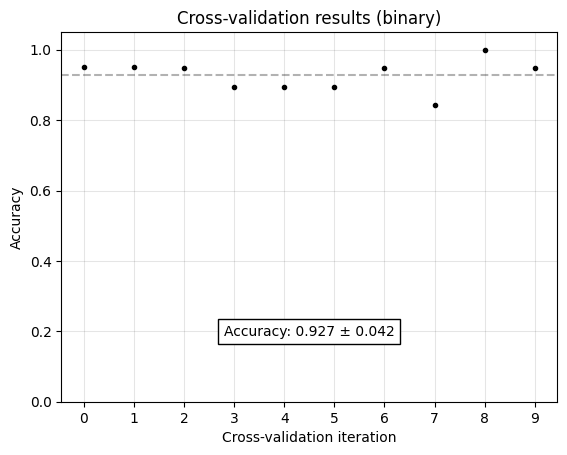

In [27]:
%%time

clf_binary = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10_000,
    ),
)



cv_result_binary = cross_validate(
    estimator=clf_binary,
    X=X,
    y=y_binary,
    cv=10,
    scoring="accuracy",
)

scores = cv_result_binary["test_score"]

fig, ax = plt.subplots()
ax.plot(scores, ls="", marker=".", c="k")
ax.set_ylim(0, 1.05)
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("Accuracy")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.axhline(scores.mean(), linestyle="dashed", alpha=0.3, c="k")
ax.annotate(
    text=f"Accuracy: {scores.mean():.3f} ± {scores.std():.3f}",
    xy=(4.5, 0.2),
    horizontalalignment="center",
    verticalalignment="center",
    bbox={
        "facecolor": "white",
    },
)
ax.set_title("Cross-validation results (binary)")
ax.grid(color="k", alpha=0.1)

Measure the performance of the trained model in unseen data:


Classification Report:

              precision    recall  f1-score   support

  Coniferous       0.97      0.95      0.96        41
   Deciduous       0.95      0.97      0.96        36

    accuracy                           0.96        77
   macro avg       0.96      0.96      0.96        77
weighted avg       0.96      0.96      0.96        77


Confussion Matrix:



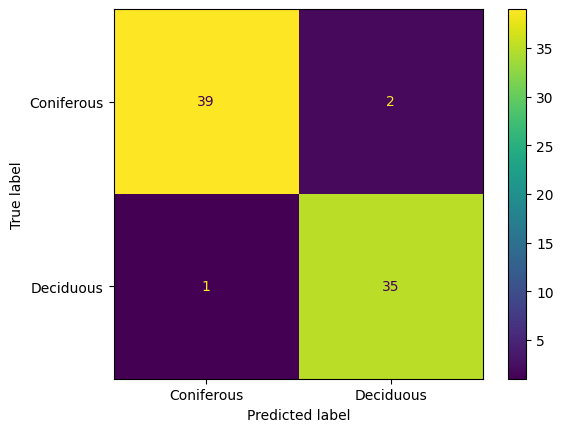

In [28]:
clf_binary.fit(X_train, y_binary_train);
pred_binary = clf_binary.predict(X_test)

print("\nClassification Report:\n")

print(classification_report(y_binary_test, pred_binary))

print("\nConfussion Matrix:\n")
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=y_binary_test,
    y_pred=pred_binary,
#     normalize="true",
)


**Review Results**

In [29]:
report = classification_report(y_binary_test, pred_binary, output_dict=True)
tn, fp, fn, tp = confusion_matrix(y_true=y_binary_test, y_pred=pred_binary).ravel()
print("When the trained model predicts that a tree is coniferous then it is correct %2.2f%% of the time (precision)." 
      % (100*report['Coniferous']['precision']))


print("\nIn the case of deciduous, the model is correct %2.2f%% of the time (precision)." 
      % (100*report['Deciduous']['precision']))

print()
print("%.d coniferous tree(s) and %.d deciduous tree(s) were not accurately predicted." 
      % (fp, fn))

When the trained model predicts that a tree is coniferous then it is correct 97.50% of the time (precision).

In the case of deciduous, the model is correct 94.59% of the time (precision).

2 coniferous tree(s) and 1 deciduous tree(s) were not accurately predicted.


Print the ids, the actual types and the predicted types of the trees that the model wrongly predicted !!!!

In [30]:
wrong_mask = pred_binary != y_binary_test

pd.DataFrame({
    "actual type": y_binary_test[wrong_mask],
    "predicted type": pred_binary[wrong_mask],
})


,actual type,predicted type
69,Deciduous,Coniferous
86,Coniferous,Deciduous
98,Coniferous,Deciduous


Store performance measurements for reporting purposes

In [31]:
binary_accuracies.append(round(report['accuracy']*100, 2))
binary_f1scores.append(round(report['macro avg']['f1-score']*100, 2))
binary_Con_precisions.append(round(report['Coniferous']['precision']*100, 2))
binary_Dec_precisions.append(round(report['Deciduous']['precision']*100, 2))
binary_Con_recalls.append(round(report['Coniferous']['recall']*100, 2))
binary_Dec_recalls.append(round(report['Deciduous']['recall']*100, 2))
binary_models.append("LR")
binary_cvs.append(f"{scores.mean():.3f} ± {scores.std():.3f}")

## SVM

*Support vector machines (**SVM**)* technique tries to find the optimal hyperplane in an N-dimensional space that can separate the data in classes in the feature space. The hyperplane tries to ensure that the margin between the closest points of different classes should be as maximum as possible. SVM tends to generalize better on unseen data and thus the risk of overfitting is low. SVM can produce reliable results even when provided with limited training samples. However, it is computationally expensive during the training phase, especially when it must be trained with large amounts of data.

The training of the SVM model follows:

In [32]:
c = 0.5
kernel = 'linear'
clf_binary = make_pipeline(
    StandardScaler(),
    SVC(kernel=kernel, C=c),
)

CPU times: total: 93.8 ms
Wall time: 214 ms


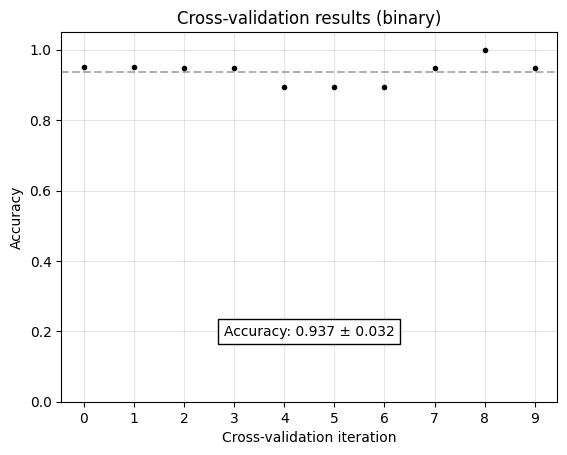

In [33]:
%%time

cv_result_binary = cross_validate(
    estimator=clf_binary,
    X=X,
    y=y_binary,
    cv=10,
    scoring="accuracy",
)

scores = cv_result_binary["test_score"]

fig, ax = plt.subplots()
ax.plot(scores, ls="", marker=".", c="k")
ax.set_ylim(0, 1.05)
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("Accuracy")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.axhline(scores.mean(), linestyle="dashed", alpha=0.3, c="k")
ax.annotate(
    text=f"Accuracy: {scores.mean():.3f} ± {scores.std():.3f}",
    xy=(4.5, 0.2),
    horizontalalignment="center",
    verticalalignment="center",
    bbox={
        "facecolor": "white",
    },
)
ax.set_title("Cross-validation results (binary)")
ax.grid(color="k", alpha=0.1)

Measure the performance of the trained model in unseen data:


Classification report:

              precision    recall  f1-score   support

  Coniferous       1.00      0.95      0.97        41
   Deciduous       0.95      1.00      0.97        36

    accuracy                           0.97        77
   macro avg       0.97      0.98      0.97        77
weighted avg       0.98      0.97      0.97        77


Confussion Matrix:



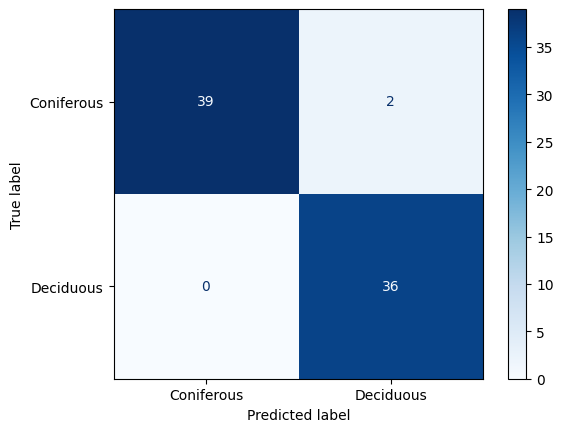

In [34]:
clf_binary.fit(X_train, y_binary_train);
pred_binary = clf_binary.predict(X_test)
print("\nClassification report:\n")
print(classification_report(y_binary_test, pred_binary))
print("\nConfussion Matrix:\n")
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=y_binary_test,
    y_pred=pred_binary,
    cmap=plt.cm.Blues
#     normalize="true",
)

**Review Results**

In [35]:
report = classification_report(y_binary_test, pred_binary, output_dict=True)
tn, fp, fn, tp = confusion_matrix(y_true=y_binary_test, y_pred=pred_binary).ravel()
print("When the trained model predicts that a tree is coniferous then it is correct %2.2f%% of the time (precision)." 
      % (100*report['Coniferous']['precision']))


print("\nIn the case of deciduous, the model is correct %2.2f%% of the time (precision)." 
      % (100*report['Deciduous']['precision']))

print()
print("%.d coniferous tree(s) and %.d deciduous tree(s) were not accurately predicted." 
      % (fp, fn))

When the trained model predicts that a tree is coniferous then it is correct 100.00% of the time (precision).

In the case of deciduous, the model is correct 94.74% of the time (precision).

2 coniferous tree(s) and 0 deciduous tree(s) were not accurately predicted.


Print the ids, the actual types and the predicted types of the trees that the model wrongly predicted !!!!

In [36]:
wrong_mask = pred_binary != y_binary_test

pd.DataFrame({
    "actual type": y_binary_test[wrong_mask],
    "predicted type": pred_binary[wrong_mask],
})

,actual type,predicted type
135,Coniferous,Deciduous
98,Coniferous,Deciduous


Store performance measurements for reporting purposes

In [37]:
binary_accuracies.append(round(report['accuracy']*100, 2))
binary_f1scores.append(round(report['macro avg']['f1-score']*100, 2))
binary_Con_precisions.append(round(report['Coniferous']['precision']*100, 2))
binary_Dec_precisions.append(round(report['Deciduous']['precision']*100, 2))
binary_Con_recalls.append(round(report['Coniferous']['recall']*100, 2))
binary_Dec_recalls.append(round(report['Deciduous']['recall']*100, 2))
binary_models.append("SVM")
binary_cvs.append(f"{scores.mean():.3f} ± {scores.std():.3f}")

## Random Forest 

The random forest algorithm creates a collection of decision trees, where each tree is based on a random subset of the training data. The final output is the prediction that has been voted by the majority of the decision trees. When the number of used decision trees is large then the accuracy gets high, and the overfitting is prevented. The random forest algorithm reduces overfitting in decision trees and helps to improve the accuracy. It requires no normalization of the training data as it uses a rule-based approach. However, it requires significant computational power as well as resources as it builds numerous trees to combine their outputs. The duration of the training is also considerable as it combines a lot of decision trees to determine the class. In any case, it provides a good trade-off between classification accuracy and computational efficiency.

The training of the RF model follows:

CPU times: total: 2.19 s
Wall time: 4.93 s


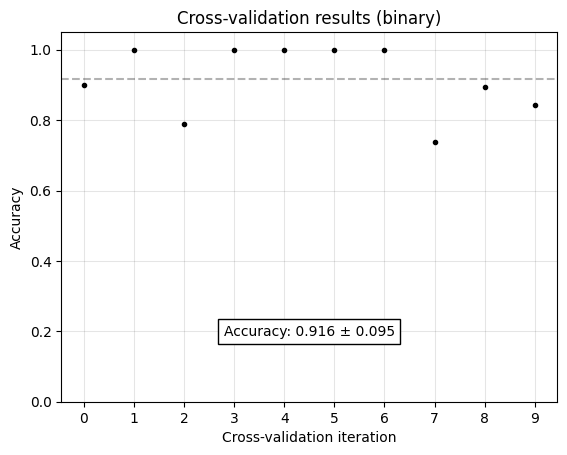

In [38]:
%%time
clf_binary = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators = 100),
)


cv_result_binary = cross_validate(
    estimator=clf_binary,
    X=X,
    y=y_binary,
    cv=10,
    scoring="accuracy",
)

scores = cv_result_binary["test_score"]

fig, ax = plt.subplots()
ax.plot(scores, ls="", marker=".", c="k")
ax.set_ylim(0, 1.05)
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("Accuracy")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.axhline(scores.mean(), linestyle="dashed", alpha=0.3, c="k")
ax.annotate(
    text=f"Accuracy: {scores.mean():.3f} ± {scores.std():.3f}",
    xy=(4.5, 0.2),
    horizontalalignment="center",
    verticalalignment="center",
    bbox={
        "facecolor": "white",
    },
)
ax.set_title("Cross-validation results (binary)")
ax.grid(color="k", alpha=0.1)

Measure the performance of the trained model in unseen data:


Classification Report:

              precision    recall  f1-score   support

  Coniferous       0.97      0.93      0.95        41
   Deciduous       0.92      0.97      0.95        36

    accuracy                           0.95        77
   macro avg       0.95      0.95      0.95        77
weighted avg       0.95      0.95      0.95        77


Confussion Matrix:



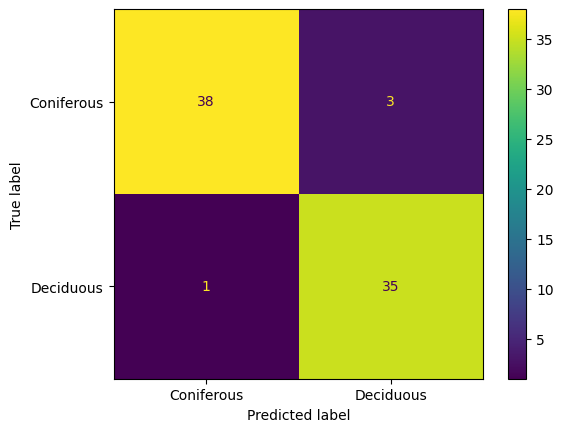

In [39]:
clf_binary.fit(X_train, y_binary_train);
pred_binary = clf_binary.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_binary_test, pred_binary))
print("\nConfussion Matrix:\n")
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=y_binary_test,
    y_pred=pred_binary,
#     normalize="true",
)
print(cm)


**Review Results**

In [40]:
report = classification_report(y_binary_test, pred_binary, output_dict=True)
tn, fp, fn, tp = confusion_matrix(y_true=y_binary_test, y_pred=pred_binary).ravel()
print("When the trained model predicts that a tree is coniferous then it is correct %2.2f of the time (precision)." 
      % (100*report['Coniferous']['precision']))


print("\nIn the case of deciduous, the model is correct %2.2f of the time (precision)." 
      % (100*report['Deciduous']['precision']))

print()
print("%.d coniferous tree(s) and %.d deciduous tree(s) were not accurately predicted." 
      % (fp, fn))

When the trained model predicts that a tree is coniferous then it is correct 97.44 of the time (precision).

In the case of deciduous, the model is correct 92.11 of the time (precision).

3 coniferous tree(s) and 1 deciduous tree(s) were not accurately predicted.


Print the ids, the actual types and the predicted types of the trees that the model wrongly predicted !!!!

In [41]:
wrong_mask = pred_binary != y_binary_test

pd.DataFrame({
    "actual type": y_binary_test[wrong_mask],
    "predicted type": pred_binary[wrong_mask],
})

,actual type,predicted type
152,Coniferous,Deciduous
69,Deciduous,Coniferous
171,Coniferous,Deciduous
98,Coniferous,Deciduous


Store performance measurements for reporting purposes

In [42]:
binary_accuracies.append(round(report['accuracy']*100, 2))
binary_f1scores.append(round(report['macro avg']['f1-score']*100, 2))
binary_Con_precisions.append(round(report['Coniferous']['precision']*100, 2))
binary_Dec_precisions.append(round(report['Deciduous']['precision']*100, 2))
binary_Con_recalls.append(round(report['Coniferous']['recall']*100, 2))
binary_Dec_recalls.append(round(report['Deciduous']['recall']*100, 2))
binary_models.append("RF")
binary_cvs.append(f"{scores.mean():.3f} ± {scores.std():.3f}")

## KNN (n=2)

The K-Nearest Neighbors (KNN) relies on the idea that similar data points tend to have similar labels or values. For each input data point, the algorithm calculates its distance from all
7
the training examples, using a chosen distance metric (i.e., Euclidean distance) and identifies its K nearest neighbours based on their distances. Then it labels the input data point with the most common class label among the K neighbors.

The KNN algorithm does not build any explicit model or generalize from the training data, and it has no explicit training step. For each new data point, the KNN automatically computes its prediction without having to retrain a new model. Therefore, it has high memory requirements and computation costs especially when it handles large datasets or datasets with high dimensions.

The training of the KNN model follows:

In [43]:
clf_binary = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=2),
)


CPU times: total: 391 ms
Wall time: 994 ms


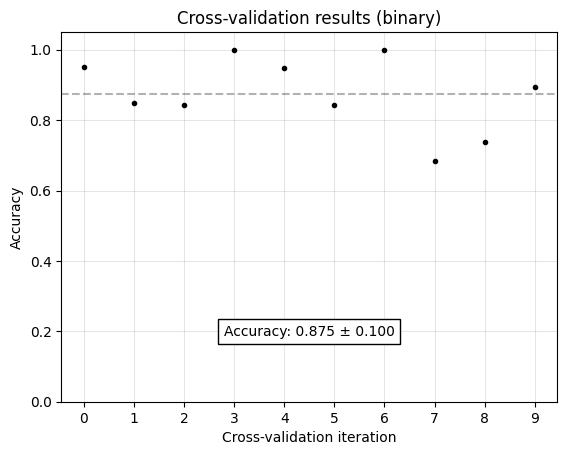

In [44]:
%%time

cv_result_binary = cross_validate(
    estimator=clf_binary,
    X=X,
    y=y_binary,
    cv=10,
    scoring="accuracy",
)

scores = cv_result_binary["test_score"]

fig, ax = plt.subplots()
ax.plot(scores, ls="", marker=".", c="k")
ax.set_ylim(0, 1.05)
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("Accuracy")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.axhline(scores.mean(), linestyle="dashed", alpha=0.3, c="k")
ax.annotate(
    text=f"Accuracy: {scores.mean():.3f} ± {scores.std():.3f}",
    xy=(4.5, 0.2),
    horizontalalignment="center",
    verticalalignment="center",
    bbox={
        "facecolor": "white",
    },
)
ax.set_title("Cross-validation results (binary)")
ax.grid(color="k", alpha=0.1)

Measure the performance of the trained model in unseen data:


Classification Report:

              precision    recall  f1-score   support

  Coniferous       0.93      1.00      0.96        41
   Deciduous       1.00      0.92      0.96        36

    accuracy                           0.96        77
   macro avg       0.97      0.96      0.96        77
weighted avg       0.96      0.96      0.96        77


Confussion Matrix:



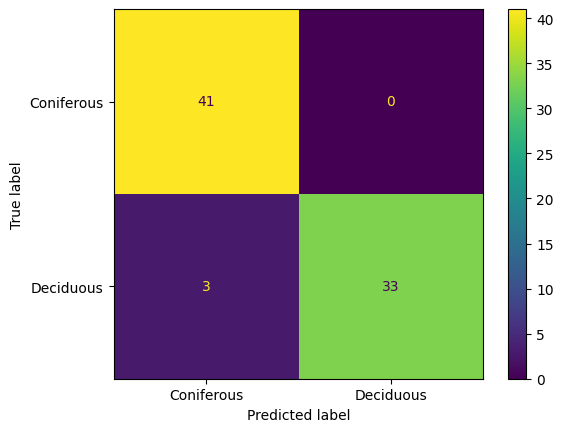

In [45]:
clf_binary.fit(X_train, y_binary_train);
pred_binary = clf_binary.predict(X_test)

print("\nClassification Report:\n")

print(classification_report(y_binary_test, pred_binary))

print("\nConfussion Matrix:\n")
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=y_binary_test,
    y_pred=pred_binary,
#     normalize="true",
)


**Review results:** 

In [46]:
report = classification_report(y_binary_test, pred_binary, output_dict=True)
tn, fp, fn, tp = confusion_matrix(y_true=y_binary_test, y_pred=pred_binary).ravel()
print("When the trained model predicts that a tree is coniferous then it is correct %2.2f%% of the time (precision)." 
      % (100*report['Coniferous']['precision']))


print("\nIn the case of deciduous, the model is correct %2.2f%% of the time (precision)." 
      % (100*report['Deciduous']['precision']))

print()
print("%.d coniferous tree(s) and %.d deciduous tree(s) were not accurately predicted." 
      % (fp, fn))

When the trained model predicts that a tree is coniferous then it is correct 93.18% of the time (precision).

In the case of deciduous, the model is correct 100.00% of the time (precision).

0 coniferous tree(s) and 3 deciduous tree(s) were not accurately predicted.


Print the ids, the actual types and the predicted types of the trees that the model wrongly predicted !!!!

In [47]:
wrong_mask = pred_binary != y_binary_test

pd.DataFrame({
    "actual type": y_binary_test[wrong_mask],
    "predicted type": pred_binary[wrong_mask],
})

,actual type,predicted type
21,Deciduous,Coniferous
69,Deciduous,Coniferous
73,Deciduous,Coniferous


Print the point cloud for each tree that the KNN (k=2) model did  not correctly predict!

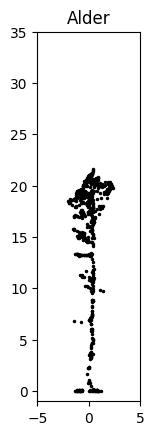

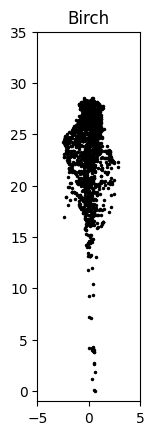

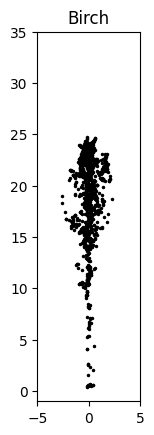

In [48]:
paths = X_test[wrong_mask].join(data)["path"].tolist()
gt = X_test[wrong_mask].join(data)["species"].tolist()

for path, species in zip(paths, gt):
    las = laspy.read(path)
    xx, yy, zz = np.rollaxis(las.xyz, axis=1)

    height_mask = zz > 0.02
    xx, yy, zz = xx[height_mask], yy[height_mask], zz[height_mask]

    fig, ax = plt.subplots()
    ax.plot(xx - xx.mean(), zz, marker=".", linestyle="", markersize=3, color="k")
    ax.set_aspect("equal")
    ax.set_title(species)
    ax.set_ylim(-1, 35)
    ax.set_xlim(-5, 5)

In [49]:
binary_accuracies.append(round(report['accuracy']*100, 2))
binary_f1scores.append(round(report['macro avg']['f1-score']*100, 2))
binary_Con_precisions.append(round(report['Coniferous']['precision']*100, 2))
binary_Dec_precisions.append(round(report['Deciduous']['precision']*100, 2))
binary_Con_recalls.append(round(report['Coniferous']['recall']*100, 2))
binary_Dec_recalls.append(round(report['Deciduous']['recall']*100, 2))
binary_models.append("KNN")
binary_cvs.append(f"{scores.mean():.3f} ± {scores.std():.3f}")

## Binary Classification - Summary Results

In [50]:
binary_results = {
    "Model": binary_models,
    "Cross Validation (%)": binary_cvs,
    "Accuracy (%)": binary_accuracies,
    "F1 Score": binary_f1scores,
    "Coniferous - Precission (%)" : binary_Con_precisions,
    "Deciduous - Precission (%)" : binary_Con_precisions,
    "Coniferous - Recall (%)" : binary_Con_precisions,
    "Deciduous - Recall (%)" : binary_Con_precisions,
}

#load data into a DataFrame object:
binary_results_df = pd.DataFrame(binary_results)
binary_results_df

,Model,Cross Validation (%),Accuracy (%),F1 Score,Coniferous - Precission (%),Deciduous - Precission (%),Coniferous - Recall (%),Deciduous - Recall (%)
0,LR,0.927 ± 0.042,96.10,96.09,97.50,97.50,97.50,97.50
1,SVM,0.937 ± 0.032,97.40,97.40,100.00,100.00,100.00,100.00
2,RF,0.916 ± 0.095,94.81,94.80,97.44,97.44,97.44,97.44
3,KNN,0.875 ± 0.100,96.10,96.06,93.18,93.18,93.18,93.18


# Multiclass classification

To determine the specific nature of the tree (e.g. pine tree, alder, etc) four (4) ML classification models were trained:
- Multinomial Logistic Regression, 
- SVM, 
- k-NN, and 
- Random Forests

### Tools to visualize training and evaluation results

The following tools are using:

**Classification report** to give a detailed summary of how the trained model is performing. It lists the values of a set of metrics such as: accuracy, precision, recall, and F1 Score.

**Confusion matrix** to summarize the performance of the ML models by displaying the number of accurate and inaccurate predictions. In a multiclass confusion matrix, the concept of "positive" and "negative" classes is replaced with the individual classes of the problem. The diagonal cells depict the presentence of the correctly classified predictions for each element while the non-diagonal elements, present the presentence of misclassified elements. The higher the values in the diagonal, the better the classifier is!


## Linear Regression

Multinomial logistic regression is a generalization of binomial logistic regression, as the dependent variable is not restricted to two classes. In our study, there are seven (7) classes each of which corresponds to a specific tree species.

The training of the LR model follows:

C:\Users\jimyd\anaconda3\envs\testing\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\jimyd\anaconda3\envs\testing\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\jimyd\anaconda3\envs\testing\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\jimyd\anaconda3\envs\testing\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: F

CPU times: total: 156 ms
Wall time: 665 ms


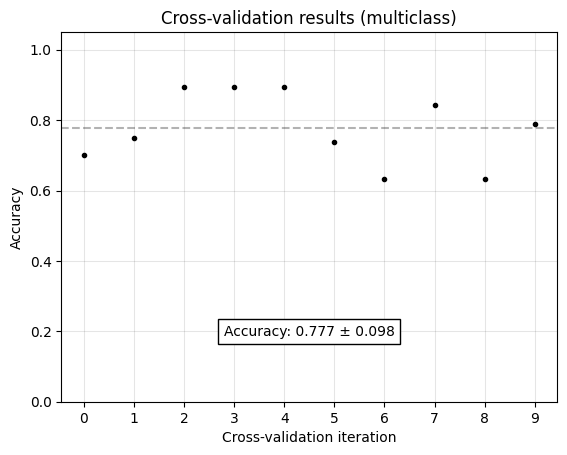

In [51]:
%%time
clf_multi = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10_000,
        multi_class="multinomial",
    ),
)


cv_result_multi = cross_validate(
    estimator=clf_multi,
    X=X,
    y=y_multi,
    cv=10,
    scoring="accuracy",
)


scores = cv_result_multi["test_score"]

fig, ax = plt.subplots()
ax.plot(scores, ls="", marker=".", c="k")
ax.set_ylim(0, 1.05)
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("Accuracy")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.axhline(scores.mean(), linestyle="dashed", alpha=0.3, c="k")
ax.annotate(
    text=f"Accuracy: {scores.mean():.3f} ± {scores.std():.3f}",
    xy=(4.5, 0.2),
    horizontalalignment="center",
    verticalalignment="center",
    bbox={
        "facecolor": "white",
    },
)
ax.set_title("Cross-validation results (multiclass)")
ax.grid(color="k", alpha=0.1)



Measure the performance of the trained model in unseen data:

C:\Users\jimyd\anaconda3\envs\testing\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

       Alder       0.60      0.60      0.60        10
       Aspen       0.89      0.89      0.89         9
       Birch       0.75      0.90      0.82        10
         Fir       0.86      0.80      0.83        15
        Pine       1.00      1.00      1.00         8
      Spruce       0.89      0.89      0.89        18
       Tilia       0.50      0.43      0.46         7

    accuracy                           0.81        77
   macro avg       0.78      0.79      0.78        77
weighted avg       0.80      0.81      0.80        77


Confussion Matrix:



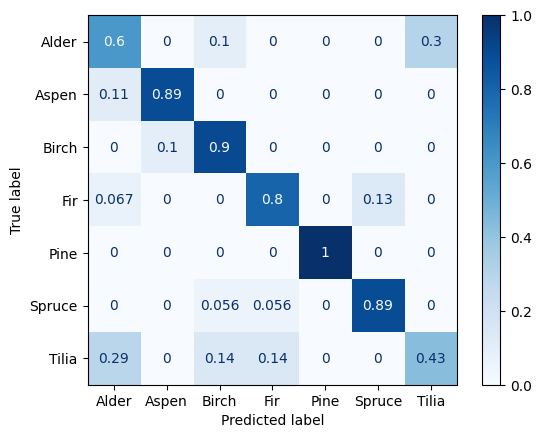

In [52]:
clf_multi.fit(X_train, y_multi_train);
pred_multi = clf_multi.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_multi_test, pred_multi))
print("\nConfussion Matrix:\n")
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=y_multi_test,
    y_pred=pred_multi,
    normalize="true",
    cmap=plt.cm.Blues
)


**Review Results**

89% of aspen trees were correctly identified while only 43% of tilia trees were correctly identified.

In [53]:
report = classification_report(y_true=y_multi_test,y_pred=pred_multi, output_dict=True)
print("The trained model accurately predicts the species of %2.2f%% of trees (accuracy)." 
      % (100*report["accuracy"]))
print("It failed to predict the Tilia trees (%2.2f%% precision) and Alder trees (%2.2f%% precision)." 
      % (100*report["Tilia"]["precision"], 100*report["Alder"]["precision"]))
print("It accurately predict the Pine trees (%2.2f%% precision)." 
      % (100*report["Pine"]["precision"]))

The trained model accurately predicts the species of 80.52% of trees (accuracy).
It failed to predict the Tilia trees (50.00% precision) and Alder trees (60.00% precision).
It accurately predict the Pine trees (100.00% precision).


Print the ids, the actual species and the predicted species of the trees that the model wrongly predicted !!!!

In [54]:
wrong_mask = pred_multi != y_multi_test

pd.DataFrame({
    "actual species": y_multi_test[wrong_mask],
    "predicted species": pred_multi[wrong_mask],
})

,actual species,predicted species
59,Birch,Aspen
88,Fir,Spruce
152,Spruce,Birch
95,Fir,Spruce
15,Alder,Tilia
12,Alder,Tilia
25,Alder,Tilia
176,Tilia,Birch
179,Tilia,Fir
171,Spruce,Fir


Store performance measurements for reporting purposes

In [57]:
multi_accuracies.append(round(report['accuracy']*100, 2))
multi_Alder_f1scores.append(round(report['Alder']['f1-score']*100, 2))
multi_Aspen_f1scores.append(round(report['Aspen']['f1-score']*100, 2))
multi_Birch_f1scores.append(round(report['Birch']['f1-score']*100, 2))
multi_Fir_f1scores.append(round(report['Fir']['f1-score']*100, 2))
multi_Pine_f1scores.append(round(report['Pine']['f1-score']*100, 2))
multi_Spruce_f1scores.append(round(report['Spruce']['f1-score']*100, 2))
multi_Tilia_f1scores.append(round(report['Tilia']['f1-score']*100, 2))
multi_models.append("LR")
multi_cvs.append(f"{scores.mean():.3f} ± {scores.std():.3f}")

## SVM

**SVM doesn’t support multiclass classification.** To overcome this, the *“One vs One” (OVO)* strategy is followed to break down the multi-classification problem into binary classification subproblems. Thus, for each pair of classes, a binary classifier is built. The majority voting principle is followed to make the final predictions.

The training of the SVM model follows:

CPU times: total: 109 ms
Wall time: 258 ms


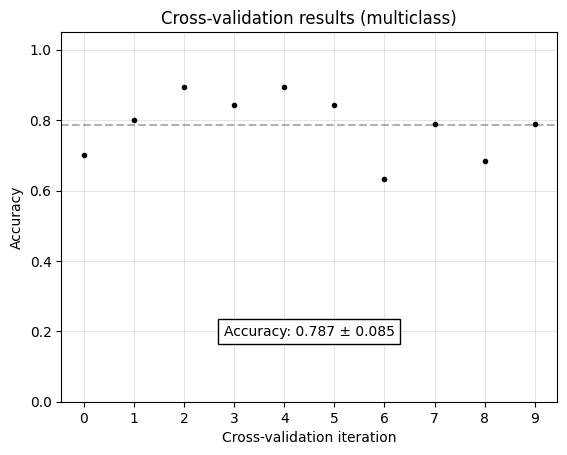

In [58]:
%%time
c = 0.5
kernel = 'linear'
clf_multi = make_pipeline(
    StandardScaler(),
    SVC(kernel=kernel, C=c),
)


cv_result_multi = cross_validate(
    estimator=clf_multi,
    X=X,
    y=y_multi,
    cv=10,
    scoring="accuracy"
)


scores = cv_result_multi["test_score"]

fig, ax = plt.subplots()
ax.plot(scores, ls="", marker=".", c="k")
ax.set_ylim(0, 1.05)
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("Accuracy")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.axhline(scores.mean(), linestyle="dashed", alpha=0.3, c="k")
ax.annotate(
    text=f"Accuracy: {scores.mean():.3f} ± {scores.std():.3f}",
    xy=(4.5, 0.2),
    horizontalalignment="center",
    verticalalignment="center",
    bbox={
        "facecolor": "white",
    },
)
ax.set_title("Cross-validation results (multiclass)")
ax.grid(color="k", alpha=0.1)


Measure the performance of the trained model in unseen data:


Classification Report:

              precision    recall  f1-score   support

       Alder       0.55      0.60      0.57        10
       Aspen       0.89      0.89      0.89         9
       Birch       0.64      0.90      0.75        10
         Fir       0.92      0.80      0.86        15
        Pine       1.00      1.00      1.00         8
      Spruce       0.88      0.78      0.82        18
       Tilia       0.50      0.43      0.46         7

    accuracy                           0.78        77
   macro avg       0.77      0.77      0.76        77
weighted avg       0.79      0.78      0.78        77


Confussion Matrix:



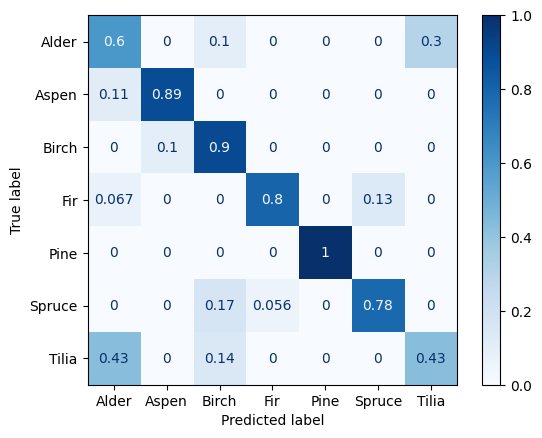

In [59]:
clf_multi.fit(X_train, y_multi_train);
pred_multi = clf_multi.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_multi_test, pred_multi))
print("\nConfussion Matrix:\n")
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=y_multi_test,
    y_pred=pred_multi,
    normalize="true",
    cmap=plt.cm.Blues
)

**Review Results**

All (100%) pine trees were accurately predicted. 30% of trees that were predicted as tilia trees were alder trees

In [60]:
report = classification_report(y_true=y_multi_test,y_pred=pred_multi, output_dict=True)
print("The trained model accurately predicts the species of %2.2f%% of trees (accuracy)." 
      % (100*report["accuracy"]))
print("It failed to predict the Tilia trees (%2.2f%% precision) and Alder trees (%2.2f%% precision)." 
      % (100*report["Tilia"]["precision"], 100*report["Alder"]["precision"]))
print("It accurately predict the Pine trees (%2.2f%% precision)." 
      % (100*report["Pine"]["precision"]))

The trained model accurately predicts the species of 77.92% of trees (accuracy).
It failed to predict the Tilia trees (50.00% precision) and Alder trees (54.55% precision).
It accurately predict the Pine trees (100.00% precision).


Print the ids, the actual species and the predicted species of the trees that the model wrongly predicted !!!!

In [61]:
wrong_mask = pred_multi != y_multi_test

pd.DataFrame({
    "actual species": y_multi_test[wrong_mask],
    "predicted species": pred_multi[wrong_mask],
})

,actual species,predicted species
59,Birch,Aspen
162,Spruce,Birch
88,Fir,Spruce
152,Spruce,Birch
95,Fir,Spruce
15,Alder,Tilia
12,Alder,Tilia
25,Alder,Tilia
176,Tilia,Birch
135,Spruce,Birch


Store performance measurements for reporting purposes

In [62]:
multi_accuracies.append(round(report['accuracy']*100, 2))
multi_Alder_f1scores.append(round(report['Alder']['f1-score']*100, 2))
multi_Aspen_f1scores.append(round(report['Aspen']['f1-score']*100, 2))
multi_Birch_f1scores.append(round(report['Birch']['f1-score']*100, 2))
multi_Fir_f1scores.append(round(report['Fir']['f1-score']*100, 2))
multi_Pine_f1scores.append(round(report['Pine']['f1-score']*100, 2))
multi_Spruce_f1scores.append(round(report['Spruce']['f1-score']*100, 2))
multi_Tilia_f1scores.append(round(report['Tilia']['f1-score']*100, 2))
multi_models.append("SVM")
multi_cvs.append(f"{scores.mean():.3f} ± {scores.std():.3f}")

## Random Forest

The random forest algorithm has widely been used in both binary and multiclass classification problems. It is also robust to outliers, good for parallelization and can handle imbalance data.

The training of the RF model follows:

CPU times: total: 2.06 s
Wall time: 5.2 s


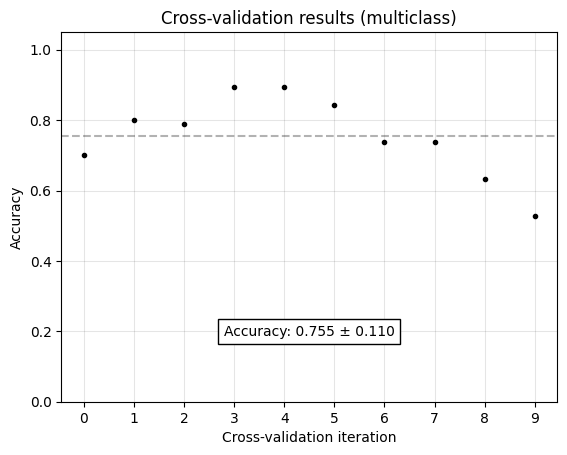

In [63]:
%%time

clf_multi = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators = 100),
)


cv_result_multi = cross_validate(
    estimator=clf_multi,
    X=X,
    y=y_multi,
    cv=10,
    scoring="accuracy",
)


scores = cv_result_multi["test_score"]

fig, ax = plt.subplots()
ax.plot(scores, ls="", marker=".", c="k")
ax.set_ylim(0, 1.05)
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("Accuracy")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.axhline(scores.mean(), linestyle="dashed", alpha=0.3, c="k")
ax.annotate(
    text=f"Accuracy: {scores.mean():.3f} ± {scores.std():.3f}",
    xy=(4.5, 0.2),
    horizontalalignment="center",
    verticalalignment="center",
    bbox={
        "facecolor": "white",
    },
)
ax.set_title("Cross-validation results (multiclass)")
ax.grid(color="k", alpha=0.1)



Measure the performance of the trained model in unseen data:


Classification Report:

              precision    recall  f1-score   support

       Alder       0.67      0.80      0.73        10
       Aspen       0.80      0.89      0.84         9
       Birch       0.73      0.80      0.76        10
         Fir       0.81      0.87      0.84        15
        Pine       1.00      1.00      1.00         8
      Spruce       0.93      0.72      0.81        18
       Tilia       0.50      0.43      0.46         7

    accuracy                           0.79        77
   macro avg       0.78      0.79      0.78        77
weighted avg       0.80      0.79      0.79        77


Confussion Matrix:



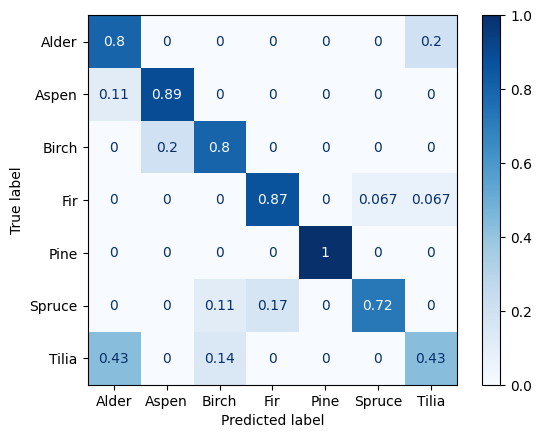

In [64]:
clf_multi.fit(X_train, y_multi_train);
pred_multi = clf_multi.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_multi_test, pred_multi))
print("\nConfussion Matrix:\n")
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=y_multi_test,
    y_pred=pred_multi,
    normalize="true",
    cmap=plt.cm.Blues
)

**Review Results**

78% of spruce trees were accurately predicted while 13% of those predicted as spruce were fir trees.

In [65]:
report = classification_report(y_true=y_multi_test,y_pred=pred_multi, output_dict=True)
print("The trained model accurately predicts the species of %2.2f%% of trees (accuracy)." 
      % (100*report["accuracy"]))
print("It failed to predict the Tilia trees (%2.2f%% precision) and Alder trees (%2.2f%% precision)." 
      % (100*report["Tilia"]["precision"], 100*report["Alder"]["precision"]))
print("It accurately predict the Pine trees (%2.2f%% precision)." 
      % (100*report["Pine"]["precision"]))

The trained model accurately predicts the species of 79.22% of trees (accuracy).
It failed to predict the Tilia trees (50.00% precision) and Alder trees (66.67% precision).
It accurately predict the Pine trees (100.00% precision).


Print the ids, the actual species and the predicted species of the trees that the model wrongly predicted !!!!

In [67]:
wrong_mask = pred_multi != y_multi_test

pd.DataFrame({
    "actual species": y_multi_test[wrong_mask],
    "predicted species": pred_multi[wrong_mask],
})

,actual species,predicted species
59,Birch,Aspen
162,Spruce,Birch
60,Birch,Aspen
152,Spruce,Birch
16,Alder,Tilia
109,Fir,Spruce
25,Alder,Tilia
176,Tilia,Birch
132,Spruce,Fir
178,Tilia,Alder


Store performance measurements for reporting purposes

In [68]:
multi_accuracies.append(round(report['accuracy']*100, 2))
multi_Alder_f1scores.append(round(report['Alder']['f1-score']*100, 2))
multi_Aspen_f1scores.append(round(report['Aspen']['f1-score']*100, 2))
multi_Birch_f1scores.append(round(report['Birch']['f1-score']*100, 2))
multi_Fir_f1scores.append(round(report['Fir']['f1-score']*100, 2))
multi_Pine_f1scores.append(round(report['Pine']['f1-score']*100, 2))
multi_Spruce_f1scores.append(round(report['Spruce']['f1-score']*100, 2))
multi_Tilia_f1scores.append(round(report['Tilia']['f1-score']*100, 2))
multi_models.append("RF")
multi_cvs.append(f"{scores.mean():.3f} ± {scores.std():.3f}")

## k-NN (n=2)

k-NN algorithm works fine in the case of multi-class classification, it still requires homogeneous data features (i.e., features that have the same scale) and it cannot perform well on an imbalanced dataset.


The training of the KNN model follows:

CPU times: total: 156 ms
Wall time: 467 ms


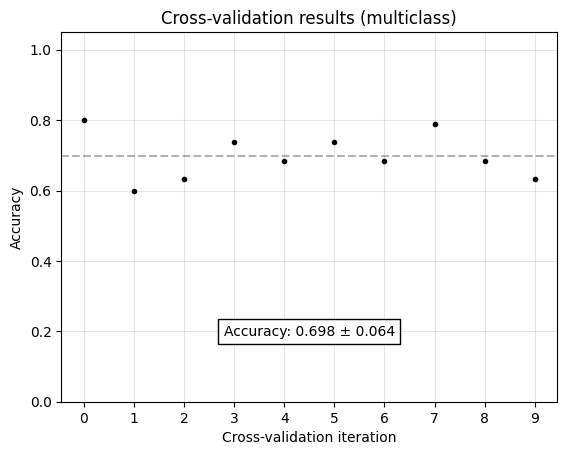

In [69]:
%%time

clf_multi = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=2),
)


cv_result_multi = cross_validate(
    estimator=clf_multi,
    X=X,
    y=y_multi,
    cv=10,
    scoring="accuracy",
)


scores = cv_result_multi["test_score"]

fig, ax = plt.subplots()
ax.plot(scores, ls="", marker=".", c="k")
ax.set_ylim(0, 1.05)
ax.set_xlabel("Cross-validation iteration")
ax.set_ylabel("Accuracy")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.axhline(scores.mean(), linestyle="dashed", alpha=0.3, c="k")
ax.annotate(
    text=f"Accuracy: {scores.mean():.3f} ± {scores.std():.3f}",
    xy=(4.5, 0.2),
    horizontalalignment="center",
    verticalalignment="center",
    bbox={
        "facecolor": "white",
    },
)
ax.set_title("Cross-validation results (multiclass)")
ax.grid(color="k", alpha=0.1)


Measure the performance of the trained model in unseen data:


Classification Report:

              precision    recall  f1-score   support

       Alder       0.50      0.80      0.62        10
       Aspen       0.90      1.00      0.95         9
       Birch       0.40      0.60      0.48        10
         Fir       0.62      0.67      0.65        15
        Pine       1.00      1.00      1.00         8
      Spruce       0.75      0.33      0.46        18
       Tilia       0.75      0.43      0.55         7

    accuracy                           0.65        77
   macro avg       0.70      0.69      0.67        77
weighted avg       0.69      0.65      0.64        77


Confussion Matrix:



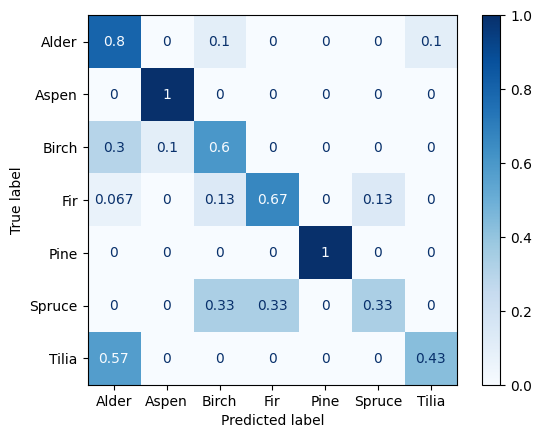

In [70]:
clf_multi.fit(X_train, y_multi_train);
pred_multi = clf_multi.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_multi_test, pred_multi))
print("\nConfussion Matrix:\n")
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=y_multi_test,
    y_pred=pred_multi,
    normalize="true",
    cmap=plt.cm.Blues
)

**Review Results**

The model predicted well (100%) aspen and pine trees.


In [71]:
report = classification_report(y_true=y_multi_test,y_pred=pred_multi, output_dict=True)
print("The trained model accurately predicts the species of %2.2f%% of trees (accuracy)." 
      % (100*report["accuracy"]))
print("It failed to predict the Tilia trees (%2.2f%% precision) and Alder trees (%2.2f%% precision)." 
      % (100*report["Tilia"]["precision"], 100*report["Alder"]["precision"]))
print("It accurately predict the Pine trees (%2.2f%% precision)." 
      % (100*report["Pine"]["precision"]))

The trained model accurately predicts the species of 64.94% of trees (accuracy).
It failed to predict the Tilia trees (75.00% precision) and Alder trees (50.00% precision).
It accurately predict the Pine trees (100.00% precision).


Print the ids, the actual species and the predicted species of the trees that the model wrongly predicted !!!!

In [72]:
wrong_mask = pred_multi != y_multi_test

pd.DataFrame({
    "actual species": y_multi_test[wrong_mask],
    "predicted species": pred_multi[wrong_mask],
})

,actual species,predicted species
59,Birch,Aspen
162,Spruce,Birch
60,Birch,Alder
152,Spruce,Birch
16,Alder,Birch
109,Fir,Spruce
161,Spruce,Fir
25,Alder,Tilia
143,Spruce,Fir
145,Spruce,Birch


Store performance measurements for reporting purposes

In [73]:
multi_accuracies.append(round(report['accuracy']*100, 2))
multi_Alder_f1scores.append(round(report['Alder']['f1-score']*100, 2))
multi_Aspen_f1scores.append(round(report['Aspen']['f1-score']*100, 2))
multi_Birch_f1scores.append(round(report['Birch']['f1-score']*100, 2))
multi_Fir_f1scores.append(round(report['Fir']['f1-score']*100, 2))
multi_Pine_f1scores.append(round(report['Pine']['f1-score']*100, 2))
multi_Spruce_f1scores.append(round(report['Spruce']['f1-score']*100, 2))
multi_Tilia_f1scores.append(round(report['Tilia']['f1-score']*100, 2))
multi_models.append("KNN")
multi_cvs.append(f"{scores.mean():.3f} ± {scores.std():.3f}")

## Multi-Class Classification - Summary Results

In [74]:
multi_results = {
    "Model": multi_models,
    "Cross Validation (%)": multi_cvs,
    "Accuracy (%)": multi_accuracies,
    "F1Score-Alder": multi_Alder_f1scores,
    "F1Score-Aspen": multi_Aspen_f1scores,
    "F1Score-Birch": multi_Birch_f1scores,
    "F1Score-Fir": multi_Fir_f1scores,
    "F1Score-Pine": multi_Pine_f1scores,
    "F1Score-Spruce": multi_Spruce_f1scores,
    "F1Score-Tilia": multi_Tilia_f1scores,
}


#load data into a DataFrame object:
multi_results_df = pd.DataFrame(multi_results)
multi_results_df

,Model,Cross Validation (%),Accuracy (%),F1Score-Alder,F1Score-Aspen,F1Score-Birch,F1Score-Fir,F1Score-Pine,F1Score-Spruce,F1Score-Tilia
0,LR,0.777 ± 0.098,80.52,60.00,88.89,81.82,82.76,100.0,88.89,46.15
1,SVM,0.787 ± 0.085,77.92,57.14,88.89,75.00,85.71,100.0,82.35,46.15
2,RF,0.755 ± 0.110,79.22,72.73,84.21,76.19,83.87,100.0,81.25,46.15
3,KNN,0.698 ± 0.064,64.94,61.54,94.74,48.00,64.52,100.0,46.15,54.55
